In [1]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2020-06-26 13:11:15--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  6.57MB/s    in 73s     

2020-06-26 13:12:29 (4.21 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [2]:
import pandas as pd
%matplotlib inline
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

In [3]:
import zipfile,os
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
 
base_dir = '/tmp/rockpaperscissors/rps-cv-images'

In [4]:
os.listdir(base_dir)

['paper', 'README_rpc-cv-images.txt', 'scissors', 'rock']

In [5]:
# for vizualisation loss and accuracy
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [14]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    height_shift_range=.2,
                    horizontal_flip=True,
                    vertical_flip = True,
                    shear_range = 0.2,
                    zoom_range=0.2,
                    validation_split = 0.2)

train_generator = train_datagen.flow_from_directory(
        base_dir, 
        target_size=(150, 150), 
        batch_size=32,
        class_mode='categorical',
        shuffle=True,
        subset='training')
 
validation_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        shuffle=False,
        subset='validation')

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax'),
])

In [16]:
# Callbacks
best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=40,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [18]:
histori = model.fit(
      train_generator,
      steps_per_epoch=25,  
      epochs=20,
      validation_data=validation_generator, 
      validation_steps=10,  
      verbose=1,
      callbacks=callbacks)

Epoch 1/20
25/25 [==============================] - ETA: 0s - loss: 1.1525 - accuracy: 0.3767
Epoch 00001: val_loss improved from inf to 0.99410, saving model to ./base.model
INFO:tensorflow:Assets written to: ./base.model/assets
25/25 [==============================] - 25s 1s/step - loss: 1.1525 - accuracy: 0.3767 - val_loss: 0.9941 - val_accuracy: 0.6687 - lr: 0.0010
Epoch 2/20
24/25 [===========================>..] - ETA: 0s - loss: 0.9798 - accuracy: 0.5247
Epoch 00002: val_loss improved from 0.99410 to 0.77438, saving model to ./base.model
INFO:tensorflow:Assets written to: ./base.model/assets
25/25 [==============================] - 26s 1s/step - loss: 0.9720 - accuracy: 0.5312 - val_loss: 0.7744 - val_accuracy: 0.7344 - lr: 0.0010
Epoch 3/20
25/25 [==============================] - ETA: 0s - loss: 0.6616 - accuracy: 0.7337
Epoch 00003: val_loss improved from 0.77438 to 0.45849, saving model to ./base.model
INFO:tensorflow:Assets written to: ./base.model/assets
25/25 [===========

In [19]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 17, 64)       

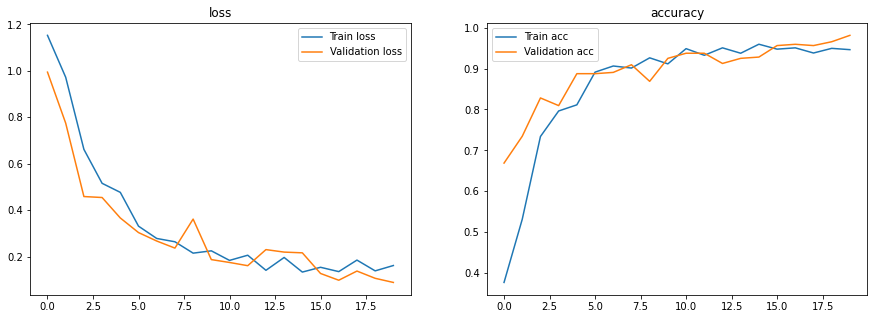

In [20]:
show_final_history(histori)
model_json = model.to_json()

Saving 4Fxr7klOIfijCpio.png to 4Fxr7klOIfijCpio.png
4Fxr7klOIfijCpio.png
kertas


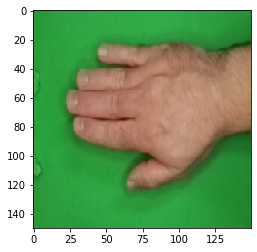

In [28]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes[0][0]==1:
    print('kertas')
  elif classes[0][1]==1:
    print('batu')
  elif classes[0][2]==1:
    print('gunting')
  else:
    print('Tidak diketahui')